In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# SIR cosine $\beta$(t), RK4 method #

In [2]:
gamma=1/10

#defining beta as a sinusoidal function of time
#beta0 is mean contact rate, beta1 is 'amplitude of seasonality'

def make_beta_func(beta0, beta1):
    beta0 = float(beta0)
    beta1 = float(beta1)

    def beta(t):
        return beta0 * (1 + beta1 * np.cos(2 * np.pi * t))

    return beta

beta0 = 0.5
beta1 = 0.3

beta_func = make_beta_func(beta0, beta1)

# Plotting $\beta$

$\beta$(t) is the time-dependent transmission rate of a disease, and represents how many infections each infected person produces per unit time.  
$\beta_0$ is the average transmission rate of a disease; a higher $\beta_0$ represents a more infectious disease.  
$\beta_1$ is the amplitude of seasonal variation; large $\beta_1$ means a drastic change in infectivity of a disease depending on time (e.g. time of year).  
The periodic oscillation has a unit of time that depends on the disease/over what length of time we are inspecting (1 unit = 1 year → yearly seasonal forcing; 1 unit = 1 day → daily cycles).

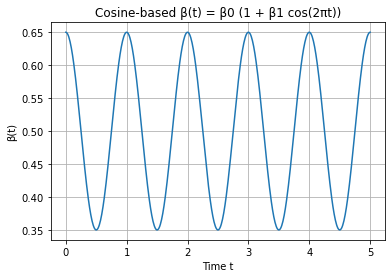

In [14]:
t = np.linspace(0, 5, 500)

# Compute beta values
beta_vals = beta_func(t)

plt.plot(t, beta_vals)
plt.title("Cosine-based β(t) = β0 (1 + β1 cos(2πt))")
plt.xlabel("Time t")
plt.ylabel("β(t)")
plt.grid(True)
plt.show()

In [3]:
def SIRK4_time_dependent_beta(i0, N, nbjours, beta_func):

    dt = 1
    S = np.zeros(nbjours)
    I = np.zeros(nbjours)
    R = np.zeros(nbjours)

    S[0] = N - i0
    I[0] = i0
    R[0] = 0

    for i in range(nbjours - 1):
        t = i * dt

        # beta values for RK4 stages
        b1 = beta_func(t)
        b2 = beta_func(t + 0.5 * dt)
        b3 = b2
        b4 = beta_func(t + dt)

        # k1
        k1_S = (-b1 * S[i] * I[i]) / N
        k1_I = (b1 * S[i] * I[i]) / N - gamma * I[i]
        k1_R = gamma * I[i]

        # k2
        S2 = S[i] + 0.5 * dt * k1_S
        I2 = I[i] + 0.5 * dt * k1_I
        R2 = R[i] + 0.5 * dt * k1_R

        k2_S = (-b2 * S2 * I2) / N
        k2_I = (b2 * S2 * I2) / N - gamma * I2
        k2_R = gamma * I2

        # k3
        S3 = S[i] + 0.5 * dt * k2_S
        I3 = I[i] + 0.5 * dt * k2_I
        R3 = R[i] + 0.5 * dt * k2_R

        k3_S = (-b3 * S3 * I3) / N
        k3_I = (b3 * S3 * I3) / N - gamma * I3
        k3_R = gamma * I3

        # k4
        S4 = S[i] + dt * k3_S
        I4 = I[i] + dt * k3_I
        R4 = R[i] + dt * k3_R

        k4_S = (-b4 * S4 * I4) / N
        k4_I = (b4 * S4 * I4) / N - gamma * I4
        k4_R = gamma * I4

        # Update
        S[i+1] = S[i] + dt*(k1_S + 2*k2_S + 2*k3_S + k4_S)/6
        I[i+1] = I[i] + dt*(k1_I + 2*k2_I + 2*k3_I + k4_I)/6
        R[i+1] = R[i] + dt*(k1_R + 2*k2_R + 2*k3_R + k4_R)/6

    return S, I, R

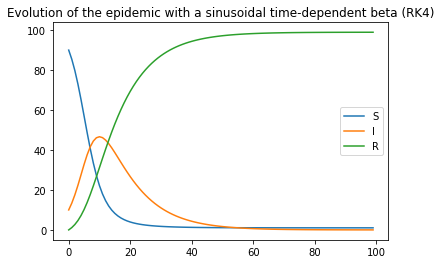

In [7]:
N = 100
i0 = 10
nbjours = 100

beta_func = make_beta_func(beta0, beta1)

S, I, R = SIRK4_time_dependent_beta(i0, N, nbjours, beta_func)

plt.plot(S, label='S')
plt.plot(I, label='I')
plt.plot(R, label='R')
plt.legend()
plt.title(f"Evolution of the epidemic with a sinusoidal time-dependent beta (RK4)")
plt.show()

# SIR cosine $\beta$(t), RK2 method #

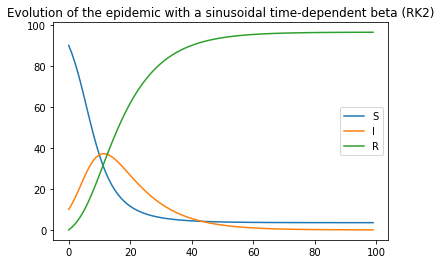

In [10]:
def SIRK2_time_dependent_beta(i0, N, nbjours, beta_func):

    dt = 1
    S = np.zeros(nbjours)
    I = np.zeros(nbjours)
    R = np.zeros(nbjours)

    S[0] = N - i0
    I[0] = i0
    R[0] = 0

    for i in range(nbjours - 1):
        t = i * dt

        b1 = beta_func(t)

        # k1
        k1_S = (-b1 * S[i] * I[i]) / N
        k1_I = (b1 * S[i] * I[i]) / N - gamma * I[i]
        k1_R = gamma * I[i]

        # midpoint estimates
        S_mid = S[i] + 0.5 * dt * k1_S
        I_mid = I[i] + 0.5 * dt * k1_I
        R_mid = R[i] + 0.5 * dt * k1_R

        b_mid = beta_func(t + 0.5 * dt)

        # k2 (midpoint slope)
        k2_S = (-b_mid * S_mid * I_mid) / N
        k2_I = (b_mid * S_mid * I_mid) / N - gamma * I_mid
        k2_R = gamma * I_mid

        # Update (RK2)
        S[i+1] = S[i] + dt * k2_S
        I[i+1] = I[i] + dt * k2_I
        R[i+1] = R[i] + dt * k2_R

    return S, I, R


# Parameters
N = 100
i0 = 10
nbjours = 100

beta_func = make_beta_func(beta0, beta1)

S, I, R = SIRK2_time_dependent_beta(i0, N, nbjours, beta_func)

plt.plot(S, label='S')
plt.plot(I, label='I')
plt.plot(R, label='R')
plt.legend()
plt.title("Evolution of the epidemic with a sinusoidal time-dependent beta (RK2)")
plt.show()

# SIR cosine $\beta$(t), Modified Euler method #

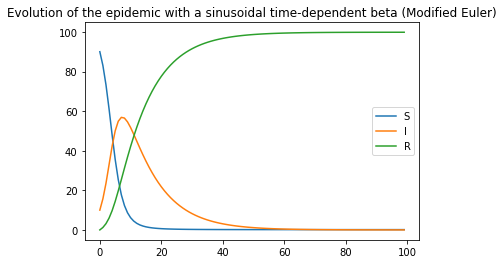

In [12]:
def SIR_modified_euler(i0, N, nbjours, beta_func):

    dt = 1
    S = np.zeros(nbjours)
    I = np.zeros(nbjours)
    R = np.zeros(nbjours)

    S[0] = N - i0
    I[0] = i0
    R[0] = 0

    for i in range(nbjours - 1):
        t = i * dt

        b1 = beta_func(t)

        # Modified Euler implementation
        k1_S = (-b1 * S[i] * I[i]) / N
        k1_I = (b1 * S[i] * I[i]) / N - gamma * I[i]
        k1_R = gamma * I[i]

        S_pred = S[i] + dt * k1_S
        I_pred = I[i] + dt * k1_I
        R_pred = R[i] + dt * k1_R

        b2 = beta_func(t + dt)

        # updating
        k2_S = (-b2 * S_pred * I_pred) / N
        k2_I = (b2 * S_pred * I_pred) / N - gamma * I_pred
        k2_R = gamma * I_pred

        S[i+1] = S[i] + 0.5 * dt * (k1_S + k2_S)
        I[i+1] = I[i] + 0.5 * dt * (k1_I + k2_I)
        R[i+1] = R[i] + 0.5 * dt * (k1_R + k2_R)

    return S, I, R


# Parameters
N = 100
i0 = 10
nbjours = 100

beta_func = make_beta_func(beta0, beta1)

S, I, R = SIR_modified_euler(i0, N, nbjours, beta_func)

plt.plot(S, label='S')
plt.plot(I, label='I')
plt.plot(R, label='R')
plt.legend()
plt.title("Evolution of the epidemic with a sinusoidal time-dependent beta (Modified Euler)")
plt.show()

# Comparing three methods' efficiency

In [13]:
import time

def time_solver(name, solver):
    start = time.perf_counter()
    S, I, R = solver(i0, N, nbjours, beta_func)
    end = time.perf_counter()
    print(f"{name} time: {end - start:.6f} seconds")

# comparing three methods
time_solver("RK4", SIRK4_time_dependent_beta)
time_solver("RK2", SIRK2_time_dependent_beta)
time_solver("Modified Euler", SIR_modified_euler)

RK4 time: 0.003794 seconds
RK2 time: 0.002233 seconds
Modified Euler time: 0.001875 seconds
